In [1]:
# 锚框
''' 
⽬标检测算法通常会在输⼊图像中采样⼤量的区域，然后判断这些区域中是否包含我们感兴趣的⽬标，并调
整区域边界从⽽更准确地预测⽬标的真实边界框（ground-truth bounding box）。不同的模型使⽤的区域采样
⽅法可能不同。这⾥我们介绍其中的⼀种⽅法：以每个像素为中⼼，⽣成多个缩放⽐和宽⾼⽐（aspect ratio）
不同的边界框。这些边界框被称为锚框（anchor box）我们将在 13.7节中设计⼀个基于锚框的⽬标检测模型。
⾸先，让我们修改输出精度，以获得更简洁的输出
'''
%matplotlib inline
import torch
from d2l import torch as d2l

# 精简输出精度
torch.set_printoptions(2) # 修改打印精度,将显示浮点tensor中元素的精度设置为2,默认为4

In [2]:
# 生成多个锚框
''' 
# 前提: 方图 SSD  size 锚框大小 ration 锚框高宽比
假设输⼊图像的⾼度为h，宽度为w。我们以图像的每个像素为中⼼⽣成不同形状的锚框：缩放⽐为s ∈ (0, 1]，
宽⾼⽐为r > 0。那么锚框的宽度和⾼度分别是ws√r和hs/√r。请注意，当中⼼位置给定时，已知宽和⾼的
锚框是确定的。
要⽣成多个不同形状的锚框，让我们设置许多缩放⽐（scale）取值s1, . . . , sn和许多宽⾼⽐（aspect ratio）
取值r1, . . . , rm。当使⽤这些⽐例和⻓宽⽐的所有组合以每个像素为中⼼时，输⼊图像将总共有whnm个锚框。
尽管这些锚框可能会覆盖所有真实边界框，但计算复杂性很容易过⾼。在实践中，我们只考虑包含s1或r1的组合：

(s1, r1), (s1, r2), . . . , (s1, rm), (s2, r1), (s3, r1), . . . , (sn, r1).

也就是说，以同⼀像素为中⼼的锚框的数量是n + m − 1。对于整个输⼊图像，我们将共⽣成 wh(n+m−1) 个
锚框。
上述⽣成锚框的⽅法在下⾯的 multibox_prior 函数中实现。我们指定输⼊图像、尺⼨列表和宽⾼⽐列表，
然后此函数将返回所有的锚框。
-------------------------------------------------------------------------------------------
multibox_prior(data, sizes, ratios):
    data=输入图像样本（批量大小，通道数，高，宽）
    sizes=包含多个锚框大小的数组 
    ratios=包含多个锚框的宽高比的数组
-------------------------------------------------------------------------------------------
torch.meshgrid(*tensors, indexing=None)
indexing-
(str，可选)：索引模式，“xy” 或“ij”，默认为“ij”
如果选择“xy”，则第一个维度对应于第二个输入的基数，第二个维度对应于第一个输入的基数。
如果选择“ij”，则维度的顺序与输入的基数相同。

警告
torch.meshgrid(*tensors) 当前与调用 numpy.meshgrid(*arrays, indexing=’ij’) 具有相同的行为。
将来 torch.meshgrid 将转换为 indexing=’xy’ 作为默认值
'''
# 缩放⽐（scale） 宽⾼⽐（aspect ratio）
# anchor表示成(xmin, ymin, xmax, ymax)

#@save
def multibox_prior(data, sizes, ratios): # multibox 多框 prior 在先的，在前的 锚框也叫先验框
    """生成以每个像素为中心具有不同形状的锚框"""
    in_height, in_width = data.shape[-2:] # 输入高宽
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios) # GPU n m
    boxes_per_pixel = (num_sizes + num_ratios - 1) # pixel 像素 每个像素有 (n + m - 1) 个anchor框
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)

    # 为了将锚点移动到像素的中心，需要设置偏移量。
    # 因为一个像素的高为1且宽为1，我们选择偏移我们的中心0.5
    offset_h, offset_w = 0.5, 0.5 # offset 抵消, 补偿  用于将anchor移动到每个像素的中心
    # steps_h, steps_w 是归一化的系数，用于将图像的宽高归一化到0到1之间
    steps_h = 1.0 / in_height  # 在y轴上缩放步长
    steps_w = 1.0 / in_width  # 在x轴上缩放步长

    # 生成锚框的所有中心点 torch.arange(in_height) tensor([0,1, ... ,(in_height-1)])
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h # 高度中心点
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    # torch.meshgrid（）的功能是生成网格，可以用于生成坐标 indexing='ij'表示维度的顺序与输入的基数相同
    # meshgrid 网格 shift_y, shift_x为中心坐标
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij') # indexing 索引模式
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1) # 将数组展平变为一维

    # 生成“ boxes_per_pixel ”个高和宽， pixel 像素
    # 之后用于创建锚框的四角坐标(xmin,xmax,ymin,ymax)
    # 只考虑包含s1或r1的组合,同⼀像素为中⼼的锚框的数量是n + m − 1
    # 对于整个输⼊图像，我们将共⽣成wh(n + m − 1)个锚框
    ''' 
    #--- w_anchor = w * s * sqrt{r} ---
    #--- 因为已经做过归一化了， 所以这里 w 就是 1 ---
    #--- 由于ssd最初是为方形图像（300x300）开发的，因此 in_height / in_width 用于处理矩形输入---
    '''
    # 处理矩形输入   \ 处于行尾做续航符
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:])))* in_height / in_width  # 使w=h
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:]))) 
    # 为了使锚框可以上下移动,除以2来获得半高和半宽
    # anchor 锚框  manipulation 伪造，篡改,操纵；控制 repeat 重复
    # PyTorch中的repeat()函数可以对张量进行重复扩充
    # 当参数只有两个时：（列的重复倍数，行的重复倍数）。1表示不重复
    # 当参数有三个时：（通道数的重复倍数，列的重复倍数，行的重复倍数）
    ''' 
    #--- w_anchor = w * s * sqrt{r} 和 h_anchor = h * s / sqrt{r} 都是正数 ---
    #--- 为了让anchor可以上下左右移动， 需要对 w_anchor 和 h_anchor 除以2再取正负 ---
    '''
    # 除以2来获得半高和半宽(半高半宽和中心坐标相加后，就得到左上角和右下角的坐标)
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(in_height * in_width, 1) / 2 

    # 每个中心点都将有“ boxes_per_pixel ”个锚框，
    # 所以生成含所有锚框中心的网格，重复了“ boxes_per_pixel ”次
    '''
    # repeat_interleave 张量沿某个维度重读n次
    # grid 格子,方格坐标
    # 形状 (h * w * (n + m - 1), 4)
    '''
    # 得到的out_grid为每个像素点中心
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                dim=1).repeat_interleave(boxes_per_pixel, dim=0) # 重复 boxes_per_pixel 次
    # 最后输出 = 每个像素点中心 + 锚框的半宽半高,即计算锚框的两角坐标(左上,右下)
    output = out_grid + anchor_manipulations # manipulation 操作
    # print(out_grid)
    # print(anchor_manipulations)
    
    # # unsqueeze()函数起升维的作用,参数表示在哪个地方加一个维度 squeeze 压缩 默认删除维度为1的维数
    # 将anchors组成batch,0表示在张量最外层加一个中括号变成第一维
    # out_grid.shape (h*w*(n + m - 1),4) -> output.unsqueeze(0).shape(1,h*w*(n + m - 1),4)
    # 第一个维度为批量大小,4为每个锚框的位置,即表示锚框的坐标
    
    # 将output扩充一维，表示一个批量增加的锚框
    return output.unsqueeze(0)  # 与批量无关,每个batch里每个都一样, 所以第一维为1 


In [3]:
# 我们可以看到返回的锚框变量Y的形状是（批量⼤⼩，锚框的数量，4）
img = d2l.plt.imread('../img/catdog.jpg')
h, w = img.shape[:2] 
print(h, w)
X = torch.rand(size=(1, 3, h, w)) # 均匀分布  批量 通道 高 宽 
# multibox_prior(data, sizes, ratios) # 生成以每个像素为中心具有不同形状的锚框
# 每个像素生成锚框的数量为 n+m-1  返回 (1,h*w*(n + m - 1),4)
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5]) # size 图片的 75% 大小
Y.shape

561 728


torch.Size([1, 2042040, 4])

In [4]:
''' 
将锚框变量Y的形状更改为(图像⾼度,图像宽度,以同⼀像素为中⼼的锚框的数量,4)后，我们可以获得以指定
像素的位置为中⼼的所有锚框。在接下来的内容中，我们访问以（250,250）为中⼼的第⼀个锚框。它有四个
元素：锚框左上⻆的(x, y)轴坐标和右下⻆的(x, y)轴坐标。将两个轴的坐标各分别除以图像的宽度和⾼度后，
所得的值介于0和1之间。
'''
# 将锚框Y的形状由(批量⼤⼩，锚框的数量，4)更改为(图像⾼度,图像宽度,以同⼀像素为中⼼的锚框的数量,4)
# 即可通过指定像素位置来获取所有以该像素为中心的锚框了
# (批量⼤⼩，所有锚框数量，锚框四角坐标) -> (⾼度,宽度,以同⼀像素为中⼼的锚框的数量,锚框四角坐标)
boxes = Y.reshape(h, w, 5, 4) # 每个像素的锚框数量 n+m-1 = 3+3-1 = 5
boxes[250, 250, :, :] # 指定(250,250)为中心,0 表示第一个锚框 : 为锚框的左上和右下坐标

tensor([[ 0.06,  0.07,  0.63,  0.82],
        [ 0.15,  0.20,  0.54,  0.70],
        [ 0.25,  0.32,  0.44,  0.57],
        [-0.06,  0.18,  0.75,  0.71],
        [ 0.14, -0.08,  0.55,  0.98]])

In [5]:
# 为了显⽰以图像中以某个像素为中⼼的所有锚框，我们定义了下⾯的show_bboxes函数来在图像上绘制多个边界框
#@save
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """显示所有边界框"""
    def _make_list(obj, default_values=None):
        if obj is None: # 如果参数里面没给obj，就用后面default_values指定的，例如下面的color就是这个意思
            obj = default_values 
        elif not isinstance(obj, (list, tuple)): # isinstance 实例 判断obj的类型是否是指定类型
            obj = [obj]
        return obj

    labels = _make_list(labels) # 将标签,颜色做成列表形式
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)] # % 取余 
        # print(i % len(colors)) # 0,1,2,3,4 # TODO: 为什么不直接用i,而要取余获得序号?
        # bbox_to_rect 将边界框转换为矩阵图格式
        rect = d2l.bbox_to_rect(bbox.detach().numpy(), color) # rect 矩形 detach 分离 
        # axes 子区域 add_axes为新增子区域,即添加锚框矩形为新的子区域
        ''' 
        # 创建画布
        fig = plt.figure(figsize=(12, 8),
                        facecolor='beige',  # 米黄色
                        )
        # 划分子区
        axes = fig.subplots(nrows=2,
                            ncols=2,
                            )
        ---------------------------------------------------------
        ax = axes[0, 0]
        circle = Circle(xy=(2, 2),  # 圆心坐标
                        radius=2,  # 半径
                        fc='white',  # facecolor
                        ec='cornflowerblue',  # 浅蓝色，矢车菊蓝
                        )       
        ax.add_patch(p=circle)
        circle.set(facecolor='yellow',
           alpha=0.5,
           hatch='/',
           ls='-.',
           ec='r'
           )
 
        # 调整坐标轴刻度范围
        ax.set(xlim=(-1, 5),
            ylim=(-1, 5)
            )

        '''
        axes.add_patch(rect) # axes.add_patch(rect)  为图像添加补丁 
        # 下面是用来进入text文字描述的
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

tensor([[ 40.13,  40.12, 460.88, 460.87],
        [110.25, 110.25, 390.75, 390.75],
        [180.38, 180.38, 320.62, 320.62],
        [-47.02, 101.74, 548.02, 399.26],
        [101.74, -47.02, 399.26, 548.02]])

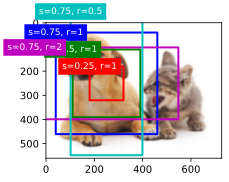

In [6]:
''' 
正如你所看到的，变量boxes中x轴和y轴的坐标值已分别除以图像的宽度和⾼度。绘制锚框时，我们需要
恢复它们原始的坐标值。因此，我们在下⾯定义了变量 bbox_scale 。现在，我们可以绘制出图像中所有
以(250,250)为中⼼的锚框了。如下所⽰，缩放⽐为0.75且宽⾼⽐为1的蓝⾊锚框很好地围绕着图像中的狗
'''
d2l.set_figsize()
bbox_scale = torch.tensor((w, h, w, h)) # 锚框的左上和右下角乘以高宽还原成原始坐标
fig = d2l.plt.imshow(img)
# boxes = Y.reshape(⾼度,宽度,以同⼀像素为中⼼的锚框的数量,锚框四角坐标)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale, # 恢复原始坐标
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2',
             's=0.75, r=0.5']) # 打印锚框
boxes[250, 250, :, :] * bbox_scale

In [7]:
# 交并比
'''
在接下来部分中，我们将使⽤交并⽐来衡量锚框和真实边界框之间、以及不同锚框之间的相似度。给定两个
锚框或边界框的列表，以下box_iou函数将在这两个列表中计算它们成对的交并⽐

边界框为真实标注 锚框为预测
''' 
#@save
def box_iou(boxes1, boxes2):
    """计算两个锚框或边界框列表中成对的交并比"""
    
    # lambda一般用于构建一个匿名函数，返回值是一个函数对象
    ''' 
    lambda 参数[,参数,参数...]：表达式
    它的返回值就是表达式的结果，所以我们只能在这里有一个表达式，
    一般用于只使用一次的情况，这时候用普通的函数声明没有必要
    '''
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1])) # 构建用于计算面积的匿名函数
    # boxes1,boxes2,areas1,areas2的形状:
    # boxes1：(boxes1的数量,4),
    # boxes2：(boxes2的数量,4),
    # areas1：(boxes1的数量,),
    # areas2：(boxes2的数量,)
    areas1 = box_area(boxes1) # 计算boxes1的面积
    areas2 = box_area(boxes2)
    # inter_upperlefts,inter_lowerrights,inters的形状:
    # (boxes1的数量,boxes2的数量,2)
    
    # 因为维度不同，这里使用了广播机制
    ''' 
    inter_upperlefts和inter_lowerrights的广播机制
    这里涉及到两个部分的内容，一个时None对于维度扩展的应用，另外就是torch.max对比大小时的广播机制：
    ----------------------------------------------------------------------------------------
    None的应用
    boxes1 = torch.tensor([[0, 0.1, 0.08, 0.52],
                          [1, 0.55, 0.2, 0.9]])
    print(boxes1[:, :2].shape )
    -->torch.Size([2, 2])
    print(boxes1[:, None, :2].shape) 
    --> torch.Size([2, 1, 2])
    ---------------------------------------------------------------------------------------
    torch.max对比方式：
    torch.max([m, 1, n], [q, n])其结果为分别将tensor1[0, :, :]与tensor2[q,:]分别对比，
    得到tensor3_1[q, n]，为两向对比的最大值，输出结果的形状为：【m, q, n】代码演示如下:
    
    boxes1 = torch.tensor([ [0, 0.1, 0.08, 0.52], 
                            [1, 0.55, 0.2, 0.9] ])
    boxes2 = torch.tensor([ [0, 0.1, 0.2, 0.3],
                            [0.15, 0.2, 0.4, 0.4], 
                            [0.63, 0.05, 0.88, 0.98],  
                            [0.66, 0.45, 0.8, 0.8], 
                            [0.57, 0.3, 0.92, 0.9] ])
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:2, :3])

    print(inter_upperlefts) -->
    
    tensor([[[0.00, 0.10],
            [0.15, 0.20],
            [0.63, 0.10]],

            [[1.00, 0.55],
            [1.00, 0.55],
            [1.00, 0.55]]])
    -----------------------------------------------------------------------------------------
    广播机制
    boxes1：tensor([[1, 1, 3, 3],
                   [0, 0, 2, 4],
                   [1, 2, 3, 4]])
    boxes2:tensor([[0, 0, 3, 3],
                   [2, 0, 5, 2]])
    由于它们的维度不同，所以要用广播机制，真正计算的时候，是下面这样的
    tensor([[[1, 1],[1, 1]],
            [[0, 0],[0, 0]],
            [[1, 2],[1, 2]]])
    tensor([[0, 0],[2, 0]]
            [[0, 0],[2, 0]]
            [[0, 0],[2, 0]])
    此时inter_upperlefts 为：
    tensor([[[1, 1],
             [2, 1]],
            [[0, 0],
            [2, 0]],
           [[1, 2],
            [2, 2]]])
    '''
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2]) # 重叠部分左上角坐标(取最大的值)
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:]) # 重叠右下
    # clamp(min=0)用来限制 inters 最小不能低于0 ,为负则说明没有交集
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0) # 
    # inter_areasandunion_areas的形状:(boxes1的数量,boxes2的数量)
    inter_areas = inters[:, :, 0] * inters[:, :, 1] # 交集
    # 这里又使用了一次广播机制
    union_areas = areas1[:, None] + areas2 - inter_areas # 并集
    return inter_areas / union_areas # 返回交并比

In [8]:
# 在训练数据中标注锚框
''' 
在训练集中，我们将每个锚框视为⼀个训练样本。为了训练⽬标检测模型，我们需要每个锚框的类别（class）
和偏移量（offset）标签，其中前者是与锚框相关的对象的类别，后者是真实边界框相对于锚框的偏移量。在
预测时，我们为每个图像⽣成多个锚框，预测所有锚框的类别和偏移量，根据预测的偏移量调整它们的位置
以获得预测的边界框，最后只输出符合特定条件的预测边界框。
我们知道，⽬标检测训练集带有“真实边界框”的位置及其包围物体类别的标签。要标记任何⽣成的锚框，我
们可以参考分配到的最接近此锚框的真实边界框的位置和类别标签。在下⽂中，我们将介绍⼀个算法，它能
够把最接近的真实边界框分配给锚框。
----------------------------------------------------------------------------------------
此算法在下⾯的 assign_anchor_to_bbox 函数中实现 assign 分配 bbox 真实边界框
'''
#@save
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """将最接近的真实边界框分配给锚框"""
    # 锚框的数量anchor[n1],真实边界框的数量[n2]
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # 位于第i行和第j列的元素x_ij是锚框i和真实边界框j的IoU
    jaccard = box_iou(anchors, ground_truth) # 交并比
    # 对于每个锚框，分配的真实边界框的张量 torch.full(size, fill_value )
    # 计算每个锚框与每个真实边界框的iou值，[n1,n2]
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                                  device=device) # 创建一个矩阵元素全为fill_value的大小为size的张量
    # 根据阈值，决定是否分配真实边界框 indices为每一行的最大值所在列，返回的为一维tensor
    max_ious, indices = torch.max(jaccard, dim=1) # 得到每一行的最大值，返回的为一维tensor
    # torch.nonzero 找出最大交并比>=交并比门槛0.5的非零元素索引
    # 根据阈值得到锚框不为背景的相应的索引值[<=n1]
    '找出每一行的最大值，并返回列坐标'
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1) # 锚框i 
    # 根据阈值得到锚框不为背景的真实边界框索引值[<=n1]，与anc_i一一对应的
    '找出锚框对应最大值中IoU值大于阈值0.5，返回列下标'
    box_j = indices[max_ious >= iou_threshold] # 边界框j 为大于等于交并比门槛的索引
    # 挑出>=iou_threshold的值,重新赋值，也就是对每个锚框，得到大于给定阈值的匹配的真实gt边界框的对应索引
    '将阈值大于0.5的与 真实边框的编号对应（也就是jaccard的列号）'
    anchors_bbox_map[anc_i] = box_j 
    # 行，列的默认值[n1],[n2]
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    
    # 以下对每个真实边界框重新分配给的锚框，所以，循环次数是 num_gt_boxes
    # 防止在最大值赋值时，某几个锚框对应同一个真实边界框
    for _ in range(num_gt_boxes):
        #取得该矩形中最大值的索引，是按reshape(-1)得到的索引 0-(n1*n2-1)
        ''' 
        在torch中argmax选取最大值，会先将矩阵拉平，
        之后找出最大值在拉平后矩阵中的下标，这个代码与后边的代码相呼应
        num_gt_boxes为jaccard矩阵的列数，则取余数（%）可以得到列数，
        取整除数可以得到行数（除法后取整）
        ---------------------------------------------------------------------------
        x = torch.randint(1,20, size=(4,5))
        print(x)
        
        tensor([[17,  8, 13,  8,  5],
            [18, 17,  5,  5, 14],
            [17,  7, 14, 11, 10],
            [ 3, 10,  9, 14,  7]])
        
        print(torch.argmax(x))
        
        拉平后下标为5
        tensor(5)
        
        print((torch.argmax(x) / 5).long())
        
        给出行数
        tensor(1)
        
        print((torch.argmax(x) % 5).long()) 
        
        给出列数
        tensor(0)
        '''
        max_idx = torch.argmax(jaccard) 
        # 得到矩阵最大值所在的列，就是对应的真实gt边界框的索引
        box_idx = (max_idx % num_gt_boxes).long() # 通过取余获得最大交并比对应的边界框索引 即列数
        # 得到矩阵最大值所在的行，是对应的锚框的索引
        anc_idx = (max_idx / num_gt_boxes).long() # 通过取除数获得最大交并比对应的锚框索引 即行数
        # 重新赋值，就是矩阵最大iou值中锚框与其对应的真实gt边界框 
        anchors_bbox_map[anc_idx] = box_idx
        '将真实框与anchors匹配，放在映射关系矩阵关系的对应位置'
        '删除不改变矩阵形状，将行列全部变成-1'
        # 将最大值所在该行置为-1
        jaccard[:, box_idx] = col_discard # 删去边界框对应的列
        # 将最大值所在该列置为-1
        jaccard[anc_idx, :] = row_discard # 删去锚框对应的行
    # 返回值是每个anchor对应的真实gt(ground truth)边界框的索引(其实是list) 
    return anchors_bbox_map

In [9]:
# 标记类别和偏移量
''' 
现在我们可以为每个锚框标记类别和偏移量了。假设⼀个锚框A被分配了⼀个真实边界框B。⼀⽅⾯，锚框A的
类别将被标记为与B相同。另⼀⽅⾯，锚框A的偏移量将根据B和A中⼼坐标的相对位置以及这两个框的相对
⼤⼩进⾏标记。鉴于数据集内不同的框的位置和⼤⼩不同，我们可以对那些相对位置和⼤⼩应⽤变换，使
其获得分布更均匀且易于拟合的偏移量。在这⾥，我们介绍⼀种常⻅的变换。给定框A和B，中⼼坐标分别
为(xa, ya)和(xb, yb)，宽度分别为wa和wb，⾼度分别为ha和hb

其中常量的默认值为 µx = µy = µw = µh = 0, σx = σy = 0.1 ，σw = σh = 0.2 
这种转换在下⾯的offset_boxes 函数中实现
'''
#@save
def offset_boxes(anchors, assigned_bb, eps=1e-6): # assigned 已分配的 指定的
    """对锚框偏移量的转换"""
    ' anchors是生成的锚框，assigned_bb是给每个锚框分配的边界框的值[n,4],[n,4] '
    # 将左上右下坐标转为中心点宽高的格式
    c_anc = d2l.box_corner_to_center(anchors) # 将两角坐标转为中心坐标
    c_assigned_bb = d2l.box_corner_to_center(assigned_bb)
    # 根据公式得到中心点xy偏移量,宽高wh的偏移量[n,2]
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    # 取log是为了防止w,h的offset远大于x,y的offset
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    #维度拼接，将维度拼接为[n,4]
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset # 返回转换后的偏移量

In [10]:
''' 
如果⼀个锚框没有被分配真实边界框，我们只需将锚框的类别标记为“背景”（background）。背景类别的
锚框通常被称为“负类”锚框，其余的被称为“正类”锚框。我们使⽤真实边界框（labels参数）实现以
下 multibox_target 函数，来标记锚框的类别和偏移量（anchors参数）。此函数将背景类别的索引设置
为零，然后将新类别的整数索引递增⼀
---------------------------------------------------------------------------------------
labels = multibox_target(anchors.unsqueeze(dim=0),
                         ground_truth.unsqueeze(dim=0)) # unsqueeze(dim=0) 增加一个批量维度
                         
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                         [1, 0.55, 0.2, 0.9, 0.88]]) # 真实边界框
'''
#@save
def multibox_target(anchors, labels): # labels -> ground_truth.unsqueeze(dim=0) 真实边界框
    """使用真实边界框标记锚框"""
    
    '''
    输入为左上右下坐标的矩形框，生成的锚框和分配给锚框的真实gt边界框
    输出的第一个维度为 batch.offset 为偏移量, mask 表每个锚框的对应类别是背景还是非背景的mask,
    类别 class_labels 表示每个锚框对应类别，0 是背景，>=1是其他类别
    '''
    batch_size, anchors = labels.shape[0], anchors.squeeze(0) 
    ''' 
    这里anchors 进行squeeze是剪掉第一个维度,也就是样本量，变成[anchors_num, 4]
    Frame coordinate 帧坐标
    '''
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :] # i对应batch_size 第二位值为0,1,表示类别,最后一位为4个参数
        '返回的为锚框与真实框的对应矩阵，-1为无对应'
        anchors_bbox_map = assign_anchor_to_bbox(
            label[:, 1:], anchors, device) # 将最接近的真实边界框分配给锚框,返回的是list
        # 边界框的mask表
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(1, 4) 
        '将锚框的映射map按列重复，这样可以在之后对偏移量对应相乘,不对应边框偏移量直接归零'
        # 将类标签和分配的边界框坐标初始化为零
        class_labels = torch.zeros(num_anchors, dtype=torch.long,
                                   device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                                  device=device)
        # 使用真实边界框来标记锚框的类别
        # 如果一个锚框没有被分配，我们标记其为背景(值为零) indices index的复数
        indices_true = torch.nonzero(anchors_bbox_map >= 0) # 返回非零值的索引
        # 由非零的索引,即map中对应的交并比的位置获取边界框的索引,标签类别以及锚框分配的边界框的值
        ''' 
        bb_idx: 返回的为可以对应锚框对应的真实边框的编号
        class_labels: 给予锚框对应的类别赋值，若为背景则赋值为0
        assigned_bb：给予锚框真实边框的对应位置
        '''
        bb_idx = anchors_bbox_map[indices_true] # 真实边界框的编号
        # labels的维度为[1, class_num, 5], [class_label, Frame coordinate:4] 
        ''' 
        label = labels[i, :, :]
        
        labels: tensor
               真实框 [batch_size, class_num, 5]
               
        anchors_bbox_map = assign_anchor_to_bbox(
            label[:, 1:], anchors, device) # 将最接近的真实边界框分配给锚框,返回的是list
        '''
        class_labels[indices_true] = label[bb_idx, 0].long() + 1 # 类标签 
        assigned_bb[indices_true] = label[bb_idx, 1:] # assigned_bb是给每个锚框分配的边界框的值
        ''' 
        print(label)  bb_idx 真实边界框的编号
        
        tensor([[0.00, 0.10, 0.08, 0.52, 0.92],
        [1.00, 0.55, 0.20, 0.90, 0.88]])
        --------------------------------------------------
        print(label[bb_idx, 0])
        
        tensor([[0.],
        [1.],
        [1.]])
        --------------------------------------------------
        print(label[bb_idx, 1:])
        
        tensor([[[0.10, 0.08, 0.52, 0.92]],
        [[0.55, 0.20, 0.90, 0.88]],
        [[0.55, 0.20, 0.90, 0.88]]])
        '''
        # 使用offset_boxes函数利用锚框与分配的边界框的值实现锚框偏移量的转换
        '''
        将真实边框与锚框所处位置相对应，无锚框为0 使用元素对应相乘
        即计算存在对应关系锚框与真实边框的偏移量，anchors与assigned_bb形状一致，
        为[anchors_num, 4], bbox_mask, 存在对应关系则整行为1，否则为0
        '''
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask 
        # print(offset) 返回对应锚框与真实边界框的偏差值 xy wh
        ''' 
        print(offset_boxes(anchors, assigned_bb))  实例为5个锚框,所以有5个偏差值
        
        tensor([[-5.00e+00, -1.00e+01, -6.91e+01, -6.91e+01],
        [ 1.40e+00,  1.00e+01,  2.59e+00,  7.18e+00],
        [-1.20e+00,  2.69e-01,  1.68e+00, -1.57e+00],
        [-5.21e+01, -1.79e+01, -6.91e+01, -6.91e+01],
        [-5.71e-01, -1.00e+00,  4.17e-06,  6.26e-01]])
        ------------------------------------------------------------
        print(offset)   offset = offset_boxes(anchors, assigned_bb) * bbox_mask 
        
        tensor([[-0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00],
        [ 1.40e+00,  1.00e+01,  2.59e+00,  7.18e+00],
        [-1.20e+00,  2.69e-01,  1.68e+00, -1.57e+00],
        [-0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00],
        [-5.71e-01, -1.00e+00,  4.17e-06,  6.26e-01]])
        '''
        batch_offset.append(offset.reshape(-1)) # 偏差批量化
        batch_mask.append(bbox_mask.reshape(-1)) # mask表批量化
        batch_class_labels.append(class_labels) # 标签批量化
    # 拼接最后返回的三个参数
    bbox_offset = torch.stack(batch_offset) # 锚框偏移量
    bbox_mask = torch.stack(batch_mask) # mask 即是否是背景
    class_labels = torch.stack(batch_class_labels) # 对应标签
    return (bbox_offset, bbox_mask, class_labels) # 返回锚框到真实边界框的offset以及锚框的mask和类别

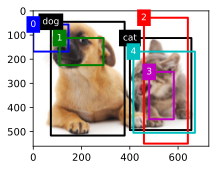

In [11]:
# ⼀个例⼦
''' 
让我们通过⼀个具体的例⼦来说明锚框标签。我们已经为加载图像中的狗和猫定义了真实边界框，其中第⼀
个元素是类别（0代表狗，1代表猫），其余四个元素是左上⻆和右下⻆的(x, y)轴坐标（范围介于0和1之间）。
我们还构建了五个锚框，⽤左上⻆和右下⻆的坐标进⾏标记：A0, . . . , A4（索引从0开始）。然后我们在图像
中绘制这些真实边界框和锚框
'''
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                         [1, 0.55, 0.2, 0.9, 0.88]]) # 真实边界框
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]]) # 锚框

fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k') # 展示真实边界框
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']); # 展示锚框

In [12]:
'''
使⽤上⾯定义的multibox_target函数，我们可以根据狗和猫的真实边界框，标注这些锚框的分类和偏移
量。在这个例⼦中，背景、狗和猫的类索引分别为0、1和2。下⾯我们为锚框和真实边界框样本添加⼀个维度。
'''
# return (bbox_offset, bbox_mask, class_labels)
labels = multibox_target(anchors.unsqueeze(dim=0),
                         ground_truth.unsqueeze(dim=0)) # unsqueeze 加一个批量维度

In [13]:
'''
返回的结果中有三个元素，都是张量格式。第三个元素包含标记的输⼊锚框的类别。

让我们根据图像中的锚框和真实边界框的位置来分析下⾯返回的类别标签。⾸先，在所有的锚框和真实边界
框配对中，锚框A4与猫的真实边界框的IoU是最⼤的。因此，A4的类别被标记为猫。去除包含A4或猫的真实
边界框的配对，在剩下的配对中，锚框A1和狗的真实边界框有最⼤的IoU。因此，A1的类别被标记为狗。接
下来，我们需要遍历剩下的三个未标记的锚框：A0、A2和A3。对于A0，与其拥有最⼤IoU的真实边界框的类
别是狗，但IoU低于预定义的阈值（0.5），因此该类别被标记为背景；对于A2，与其拥有最⼤IoU的真实边界
框的类别是猫，IoU超过阈值，所以类别被标记为猫；对于A3，与其拥有最⼤IoU的真实边界框的类别是猫，
但值低于阈值，因此该类别被标记为背景
'''
labels[2] # 输入锚框的类别 0 背景 1 狗 2 猫 [背景 狗 猫 背景 猫]

tensor([[0, 1, 2, 0, 2]])

In [14]:
''' 
返回的第⼆个元素是掩码（mask）变量，形状为（批量⼤⼩，锚框数的四倍）。掩码变量中的元素与每个锚
框的4个偏移量⼀⼀对应。由于我们不关⼼对背景的检测，负类的偏移量不应影响⽬标函数。通过元素乘法，
掩码变量中的零将在计算⽬标函数之前过滤掉负类偏移量
'''
labels[1] # mask掩码变量,记录是是否是背景 0为背景,1为非背景

tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
         1., 1.]])

In [15]:
# 返回的第⼀个元素包含了为每个锚框标记的四个偏移值。请注意，负类锚框的偏移量被标记为零
labels[0] # 偏移值offser,其中负类锚框的offset标记为0

tensor([[-0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00,  1.40e+00,  1.00e+01,
          2.59e+00,  7.18e+00, -1.20e+00,  2.69e-01,  1.68e+00, -1.57e+00,
         -0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00, -5.71e-01, -1.00e+00,
          4.17e-06,  6.26e-01]])

In [16]:
# 使用非极大值抑制预测边界框
# 应用逆偏移变换返回预测的边界框坐标
''' 
在预测时，我们先为图像⽣成多个锚框，再为这些锚框⼀⼀预测类别和偏移量。⼀个“预测好的边界框”则
根据其中某个带有预测偏移量的锚框⽽⽣成。下⾯我们实现了offset_inverse函数，该函数将锚框和偏移
量预测作为输⼊，并应⽤逆偏移变换来返回预测的边界框坐标
'''
#@save
def offset_inverse(anchors, offset_preds): # 由逆偏移变换来返回预测的边界框坐标
    """根据带有预测偏移量的锚框来预测边界框"""
    anc = d2l.box_corner_to_center(anchors) # 两角表示转中心表示
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2] # 预测xy
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:] # 预测 wh
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1) # 拼接xy与wh
    # 通过预测的xywh进行中心表示转两角表示获取预测边界框
    predicted_bbox = d2l.box_center_to_corner(pred_bbox) 
    return predicted_bbox # 返回预测的边界框

In [17]:
''' 
当有许多锚框时，可能会输出许多相似的具有明显重叠的预测边界框，都围绕着同⼀⽬标。为了简化输出，我
们可以使⽤⾮极⼤值抑制（non-maximum suppression ，NMS）合并属于同⼀⽬标的类似的预测边界框
------------------------------------------------------------------------------------------
以下是⾮极⼤值抑制的⼯作原理。对于⼀个预测边界框B，⽬标检测模型会计算每个类别的预测概率。假设
最⼤的预测概率为p，则该概率所对应的类别B即为预测的类别。具体来说，我们将p称为预测边界框B的置
信度（confidence）。在同⼀张图像中，所有预测的⾮背景边界框都按置信度降序排序，以⽣成列表L。然后
我们通过以下步骤操作排序列表L：

1. 从L中选取置信度最⾼的预测边界框B1作为基准，然后将所有与B1的IoU超过预定阈值ϵ的⾮基准预测
边界框从L中移除。这时，L保留了置信度最⾼的预测边界框，去除了与其太过相似的其他预测边界框。
简⽽⾔之，那些具有⾮极⼤值置信度的边界框被抑制了。

2. 从L中选取置信度第⼆⾼的预测边界框B2作为⼜⼀个基准，然后将所有与B2的IoU⼤于ϵ的⾮基准预测
边界框从L中移除。

3. 重复上述过程，直到L中的所有预测边界框都曾被⽤作基准。此时，L中任意⼀对预测边界框的IoU都⼩
于阈值ϵ；因此，没有⼀对边界框过于相似。

4. 输出列表L中的所有预测边界框。

-------------------------------------------------------------------------------------------
torch.sort(a,dim,descending)
输入a，在dim维进行排序，descending控制是否降序,默认为False。
输出排序后的值以及对应值在原a中的下标
'''
# nms函数 按降序对置信度进⾏排序并返回其索引
#@save
def nms(boxes, scores, iou_threshold): # 非极大值抑制
    """对预测边界框的置信度进行排序"""
    # argsort()函数默认将元素从小到大排列，提取其对应的索引输出  scores 概率p,即置信度
    B = torch.argsort(scores, dim=-1, descending=True) # 按降序对置信度进行排序
    # print(B) -> tensor([0, 3, 1, 2])
    keep = []  # 保留预测边界框的指标
    while B.numel() > 0: # B.numel() 获取B中一共包含的元素数量
        i = B[0] # 取B的第一个元素，也就是最大的预测概率
        keep.append(i) # 保留具有最大置信度的B[0]
        if B.numel() == 1: break # 如果B的元素数量为1,即取完所有的类,则直接跳出循环
        # 计算最大预测概率相应的锚框与其他所有锚框的iou
        iou = box_iou(boxes[i, :].reshape(-1, 4),
                      boxes[B[1:], :].reshape(-1, 4)).reshape(-1) # 计算边界框B[i,:]与B[1:]的交并比
        # 与B[0]的iou大于某个阈值的边界框去掉,保留小于阈值的
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1) # 返回符合阈值的非零索引
        # print(inds) -> tensor([0])
        # 此处加1,是说iou列表的下标要加1，才能得到对应B列表中的下标，
        # 因为在上面算IOU时，经过排序的最大元素是作为基准的与之进行IOU计算的其他元素会向前提一个下标
        B = B[inds + 1] # 去掉大于阈值的,剩下的变成B在循环直到B.numel()=0 
        # print(B) # -> tensor([3])
    return torch.tensor(keep, device=boxes.device) # 返回保留的预测边界框指标并显示边界框所在的设备

In [18]:
''' 
我们定义以下 multibox_detection 函数来将⾮极⼤值抑制应⽤于预测边界框。如果你发现实现有点复杂，
请不要担⼼。我们将在实现之后，⻢上⽤⼀个具体的例⼦来展⽰它是如何⼯作的
'''
#@save
# 将⾮极⼤值抑制应⽤于预测边界框
# threshold 门槛 cls_probs 每个类别的预测概率值 pos_threshold 非背景预测阈值 nms_threshold 非极大值抑制阈值
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999): # 将⾮极⼤值抑制应⽤于预测边界框
    """使用非极大值抑制来预测边界框"""
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0) # 去除批量维度
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2] # 类别数 锚框数
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4) # 获取预测类别概率与偏移
        conf, class_id = torch.max(cls_prob[1:], 0) # 找到每一个锚框中最大的预测概率，并返回值与索引
        predicted_bb = offset_inverse(anchors, offset_pred) # 根据预测偏移得到预测边界框
        
        # 非极大值抑制 nms(boxes, scores, iou_threshold)  按降序对置信度进⾏排序并返回其索引
        keep = nms(predicted_bb, conf, nms_threshold) # 预测边界框 conf 预测概率(置信度) 阈值

        # 找到所有的 non_keep 索引，并将类设置为背景
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device) # 构建所有索引
        combined = torch.cat((keep, all_idx)) # 将keep与新生成的all_idx组合起来
        # unique()  去除其中重复的元素,并按元素由小到大返回一个新的无元素重复的元组或者列表
        # return_counts=True：统计新列表元素中出现过的次数
        uniques, counts = combined.unique(return_counts=True) # 返回唯一元素列表并记录元素出现次数
        non_keep = uniques[counts == 1] # 找出只出现过一次的元素索引 不保存,做背景
        
        # 得到所有的锚框ID，前面是最大预测概率，后面是被抑制的锚框 
        all_id_sorted = torch.cat((keep, non_keep)) 
        class_id[non_keep] = -1 # 将被抑制的锚框标注在置信度索引中
        class_id = class_id[all_id_sorted] # 将class_id按照all_id_sorted顺序排序
        # 将conf, predicted_bb按照all_id_sorted顺序排序
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        below_min_idx = (conf < pos_threshold) # pos_threshold 是一个用于非背景预测的阈值
        class_id[below_min_idx] = -1 # 将背景的对应锚框ID改为-1
        conf[below_min_idx] = 1 - conf[below_min_idx] # 将背景对应锚框取预测概率相反值
        ''' 
        # 将锚框所有属性拼接起来
        # 第一个索引为预测的类索引
        # 第二个索引是预测边界框的置信度
        # 第三到第六个索引是锚框坐标
        '''
        pred_info = torch.cat((class_id.unsqueeze(1),
                               conf.unsqueeze(1),
                               predicted_bb), dim=1) # 预测信息
        out.append(pred_info)
    return torch.stack(out)

In [19]:
''' 
现在让我们将上述算法应⽤到⼀个带有四个锚框的具体⽰例中。为简单起⻅，我们假设预测的偏移量都是零，
这意味着预测的边界框即是锚框。对于背景、狗和猫其中的每个类，我们还定义了它的预测概率
'''
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                      [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]]) # 四个锚框
offset_preds = torch.tensor([0] * anchors.numel()) # anchors.numel() 获取锚框数量
cls_probs = torch.tensor([[0] * 4,            # 背景的预测概率
                      [0.9, 0.8, 0.7, 0.1],   # 狗的预测概率
                      [0.1, 0.2, 0.3, 0.9]])  # 猫的预测概率

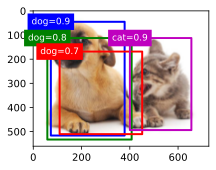

In [20]:
# 我们可以在图像上绘制这些预测边界框和置信度
fig = d2l.plt.imshow(img)
# # fig.axes 向fig中添加锚框
show_bboxes(fig.axes, anchors * bbox_scale,
            ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9']) # 偏差为0,锚框即为边界框

In [21]:
''' 
现在我们可以调⽤multibox_detection函数来执⾏⾮极⼤值抑制，其中阈值设置为0.5。请注意，我们在
⽰例的张量输⼊中添加了维度

我们可以看到返回结果的形状是(批量⼤⼩，锚框的数量，6)。最内层维度中的六个元素提供了同⼀预测
边界框的输出信息。第⼀个元素是预测的类索引，从0开始（0代表狗，1代表猫），值-1表⽰背景或在⾮极⼤
值抑制中被移除了。第⼆个元素是预测的边界框的置信度。其余四个元素分别是预测边界框左上⻆和右下⻆
的(x, y)轴坐标（范围介于0和1之间）
'''
# 调⽤multibox_detection函数来执⾏⾮极⼤值抑制
output = multibox_detection(cls_probs.unsqueeze(dim=0),    # 添加维度
                            offset_preds.unsqueeze(dim=0), # 添加维度
                            anchors.unsqueeze(dim=0),      # 添加维度
                            nms_threshold=0.5) # 返回(批量⼤⼩，锚框的数量，6)

''' 
output
tensor([[[ 0.00,  0.90,  0.10,  0.08,  0.52,  0.92],
         [ 1.00,  0.90,  0.55,  0.20,  0.90,  0.88],
         [-1.00,  0.80,  0.08,  0.20,  0.56,  0.95],
         [-1.00,  0.70,  0.15,  0.30,  0.62,  0.91]]])
----------------------------------------------------
output[0] # 第一个维度,即批量维度

tensor([[ 0.00,  0.90,  0.10,  0.08,  0.52,  0.92],
        [ 1.00,  0.90,  0.55,  0.20,  0.90,  0.88],
        [-1.00,  0.80,  0.08,  0.20,  0.56,  0.95],
        [-1.00,  0.70,  0.15,  0.30,  0.62,  0.91]])
----------------------------------------------------
output[0,0]

tensor([0.00, 0.90, 0.10, 0.08, 0.52, 0.92])
'''
output # (类别 置信度 左上右下坐标)


tensor([[[ 0.00,  0.90,  0.10,  0.08,  0.52,  0.92],
         [ 1.00,  0.90,  0.55,  0.20,  0.90,  0.88],
         [-1.00,  0.80,  0.08,  0.20,  0.56,  0.95],
         [-1.00,  0.70,  0.15,  0.30,  0.62,  0.91]]])

[[ 0.          0.9         0.10000001  0.07999998  0.52        0.92      ]
 [ 1.          0.9         0.5500001   0.20000002  0.9         0.88      ]
 [-1.          0.8         0.07999998  0.19999999  0.56        0.95      ]
 [-1.          0.7         0.14999999  0.3         0.62        0.91      ]]
0.0
0.9
dog=0.9
1.0
0.9
cat=0.9


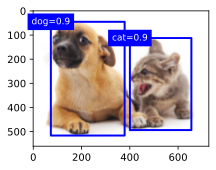

In [22]:
# 删除-1类别（背景）的预测边界框后，我们可以输出由⾮极⼤值抑制保存的最终预测边界框

''' 
def show_bboxes(axes, bboxes, labels=None, colors=None):

        ......
        ......
    
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))
'''
fig = d2l.plt.imshow(img)
print(output[0].detach().numpy())

for i in output[0].detach().numpy():
    if i[0] == -1: # 跳过i[0]== -1的情况,即去除背景
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1]) 
    print(i[0]) # i[0] 类别标签 
    print(i[1]) # i[1] 置信度
    print(label)
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label) 

In [23]:
''' 
实践中，在执⾏⾮极⼤值抑制前，我们甚⾄可以将置信度较低的预测边界框移除，从⽽减少此算法中的计算
量。我们也可以对⾮极⼤值抑制的输出结果进⾏后处理。例如，只保留置信度更⾼的结果作为最终输出
----------------------------------------------------------------------------------------
⼩结
• 我们以图像的每个像素为中⼼⽣成不同形状的锚框。
• 交并⽐（IoU）也被称为杰卡德系数，⽤于衡量两个边界框的相似性。它是相交⾯积与相并⾯积的⽐率。
• 在训练集中，我们需要给每个锚框两种类型的标签class。⼀个是与锚框中⽬标检测的类别，另⼀个是
锚框真实相对于边界框的偏移量offset。
• 在预测期间，我们可以使⽤⾮极⼤值抑制（NMS）来移除类似的预测边界框，从⽽简化输出
'''

' \n实践中，在执⾏⾮极⼤值抑制前，我们甚⾄可以将置信度较低的预测边界框移除，从⽽减少此算法中的计算\n量。我们也可以对⾮极⼤值抑制的输出结果进⾏后处理。例如，只保留置信度更⾼的结果作为最终输出\n----------------------------------------------------------------------------------------\n⼩结\n• 我们以图像的每个像素为中⼼⽣成不同形状的锚框。\n• 交并⽐（IoU）也被称为杰卡德系数，⽤于衡量两个边界框的相似性。它是相交⾯积与相并⾯积的⽐率。\n• 在训练集中，我们需要给每个锚框两种类型的标签class。⼀个是与锚框中⽬标检测的类别，另⼀个是\n锚框真实相对于边界框的偏移量offset。\n• 在预测期间，我们可以使⽤⾮极⼤值抑制（NMS）来移除类似的预测边界框，从⽽简化输出\n'